**ENTREGA FINAL**

***Grupo 8*** - Karen Baz, Federico Novelli

*Importacion de librerias necesarias para este proyecto*

In [605]:
import numpy as np
import pandas as pd
import statsmodels as st
import matplotlib.pyplot as plt
import statsmodels.api as sm           
import statsmodels.formula.api as smf  
import scipy as stast
import sklearn as skl         
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

*Importacion de dataset*

In [606]:
rawDataSet = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [607]:
rawDataSet.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


**PARTE 1: EXPLORATORY DATA ANALYSIS**

In [608]:
rawDataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [609]:
print(rawDataSet.isna().sum())

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


*No tenemos valores faltantes por lo que no es necesario hacer un Data Cleaning*

In [610]:
100*rawDataSet['DEATH_EVENT'].value_counts()/len(rawDataSet['DEATH_EVENT'])

0    67.892977
1    32.107023
Name: DEATH_EVENT, dtype: float64

*A partir del último calculo podemos ver que estamos frente a un set de datos fuertemente desbalanceado. Tenemos mas de dos tercios de personas que no han muerto.*

In [611]:
rawDataSet.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


*Hay participantes que fueron observados por 4 días. Es un tiempo muy reducido como para poder tener una evaluación consistente.*

*Consideramos que en menos de 3 meses, no se puede obtener información que pueda ser útil para tener observaciones generalizadas. Es por esto que descartamos aquellas instancias que cuentan con tiempo de observación menor a 90 días.*

*Como voy a empezar a modificar el set de datos, creo una copia así no pierdo la información original.*

In [612]:
dataSet = rawDataSet.copy()
dataSet.drop(dataSet[dataSet.time < 90].index, inplace=True)
dataSet.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,59.372138,0.412698,570.301587,0.412698,38.910053,0.301587,259251.166402,1.301746,136.714286,0.634921,0.306878,177.455026,0.153439
std,11.026656,0.493627,708.329665,0.493627,11.077933,0.460166,92964.823289,0.903087,4.274225,0.482731,0.462423,54.825879,0.361368
min,40.000000,0.000000,30.000000,0.000000,17.000000,0.000000,25100.000000,0.500000,113.000000,0.000000,0.000000,90.000000,0.000000
25%,50.000000,0.000000,129.000000,0.000000,30.000000,0.000000,215000.000000,0.900000,134.000000,0.000000,0.000000,120.000000,0.000000
50%,60.000000,0.000000,291.000000,0.000000,38.000000,0.000000,257000.000000,1.100000,137.000000,1.000000,0.000000,187.000000,0.000000
75%,65.000000,1.000000,582.000000,1.000000,45.000000,1.000000,300000.000000,1.300000,139.000000,1.000000,1.000000,215.000000,0.000000
max,90.000000,1.000000,4540.000000,1.000000,70.000000,1.000000,742000.000000,9.000000,148.000000,1.000000,1.000000,285.000000,1.000000


In [613]:
100*dataSet['DEATH_EVENT'].value_counts()/len(dataSet['DEATH_EVENT'])

0    84.656085
1    15.343915
Name: DEATH_EVENT, dtype: float64

*Vemos que ahora quedó aún más desbalanceado el set de datos*

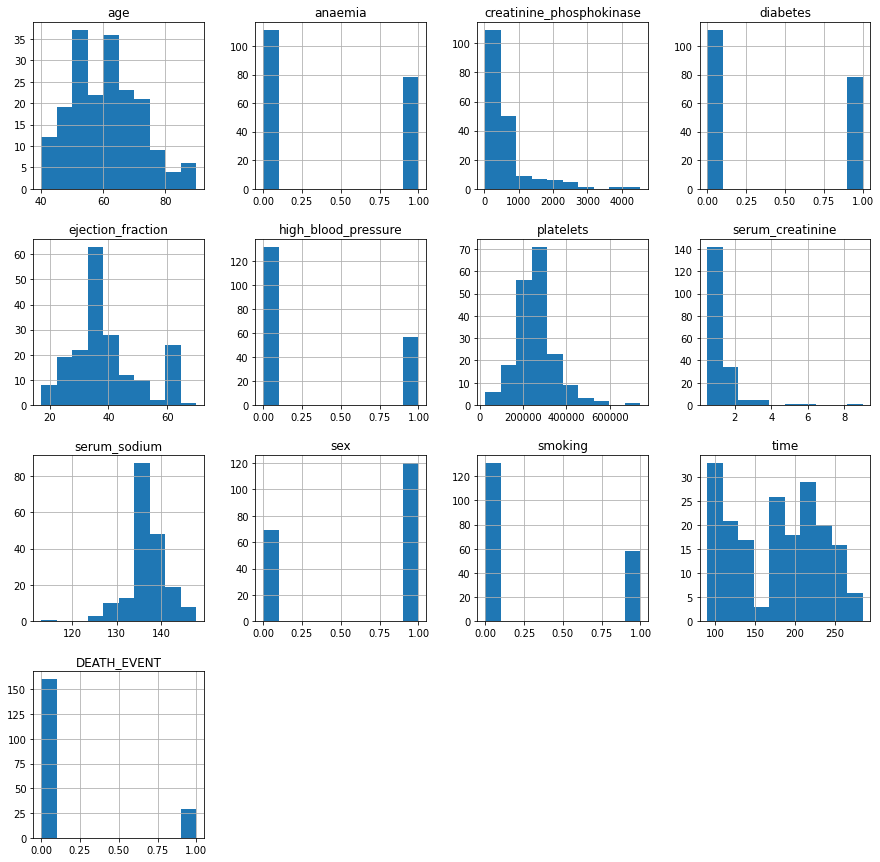

In [614]:
dataSet.hist(figsize = (15,15));

In [615]:
bins = []
for i in range(12):
    bins.append(40 + (i)*40/8)
print(bins)

[40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0]


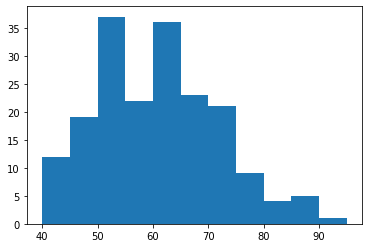

In [616]:
plt.hist(dataSet['age'], bins);
plt.show;

*Analisis del data set segun su resultado final*

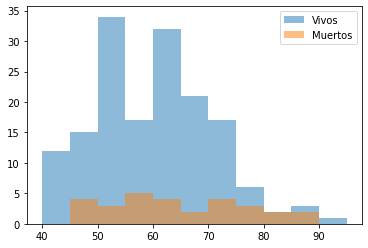

In [617]:
# separamos el dataset en dos segun si muere o no
deathDataSet = dataSet[dataSet['DEATH_EVENT'] == 1]
aliveDataSet = dataSet[dataSet['DEATH_EVENT'] == 0]
plt.hist(aliveDataSet['age'], bins, alpha = 0.5, label = 'Vivos')
plt.hist(deathDataSet['age'], bins, alpha = 0.5, label = 'Muertos')
plt.legend(loc = 'upper right')
plt.show()

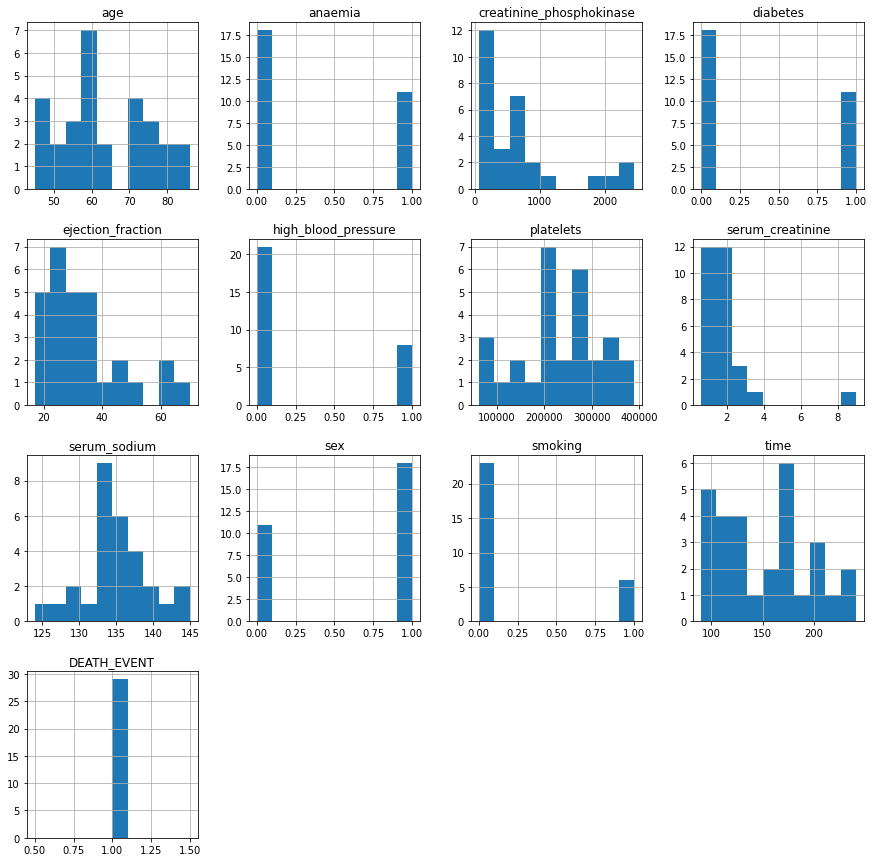

In [618]:
deathDataSet.hist(figsize = (15,15));

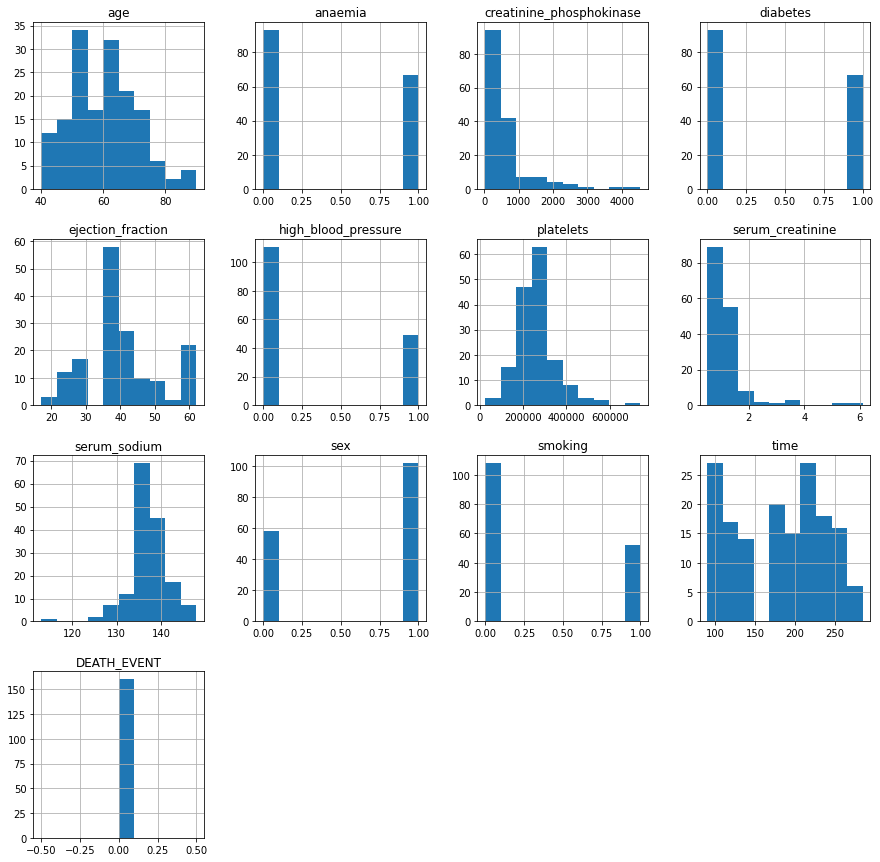

In [619]:
aliveDataSet.hist(figsize = (15,15));

In [620]:
deathDataSet.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.0
mean,63.436793,0.379310,653.862069,0.379310,33.758621,0.275862,235221.797241,1.893793,135.137931,0.620690,0.206897,152.896552,1.0
std,12.228348,0.493804,684.152851,0.493804,13.316625,0.454859,85362.731253,1.500101,4.429803,0.493804,0.412251,44.611293,0.0
min,45.000000,0.000000,66.000000,0.000000,17.000000,0.000000,62000.000000,0.600000,124.000000,0.000000,0.000000,90.000000,1.0
25%,55.000000,0.000000,166.000000,0.000000,25.000000,0.000000,198000.000000,1.200000,134.000000,0.000000,0.000000,113.000000,1.0
50%,60.000000,0.000000,427.000000,0.000000,30.000000,0.000000,235000.000000,1.600000,135.000000,1.000000,0.000000,154.000000,1.0
75%,73.000000,1.000000,776.000000,1.000000,38.000000,1.000000,271000.000000,1.830000,137.000000,1.000000,0.000000,180.000000,1.0
max,86.000000,1.000000,2442.000000,1.000000,70.000000,1.000000,389000.000000,9.000000,145.000000,1.000000,1.000000,241.000000,1.0


In [621]:
aliveDataSet.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.0
mean,58.635419,0.418750,555.156250,0.418750,39.843750,0.306250,263606.489562,1.194438,137.000000,0.637500,0.325000,181.906250,0.0
std,10.671042,0.494903,713.660063,0.494903,10.399895,0.462382,93867.696512,0.701796,4.196435,0.482231,0.469845,55.441033,0.0
min,40.000000,0.000000,30.000000,0.000000,17.000000,0.000000,25100.000000,0.500000,113.000000,0.000000,0.000000,90.000000,0.0
25%,50.000000,0.000000,120.500000,0.000000,35.000000,0.000000,215000.000000,0.900000,135.000000,0.000000,0.000000,121.000000,0.0
50%,60.000000,0.000000,263.500000,0.000000,38.000000,0.000000,259500.000000,1.000000,137.000000,1.000000,0.000000,192.000000,0.0
75%,65.000000,1.000000,582.000000,1.000000,45.000000,1.000000,300250.000000,1.200000,140.000000,1.000000,1.000000,222.500000,0.0
max,90.000000,1.000000,4540.000000,1.000000,62.000000,1.000000,742000.000000,6.100000,148.000000,1.000000,1.000000,285.000000,0.0


*Vamos a ver si existe correlacion directa entre muerte y alguna variable*

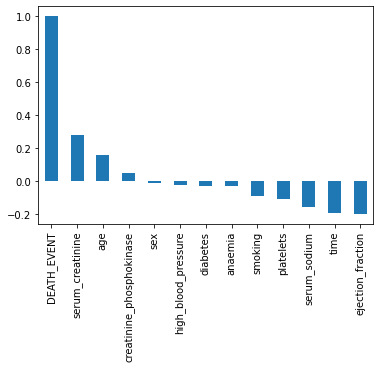

In [622]:
dataSet.corr()['DEATH_EVENT'].sort_values(ascending = False).plot(kind = 'bar');

*Vemos correlacion entre todas las variables*

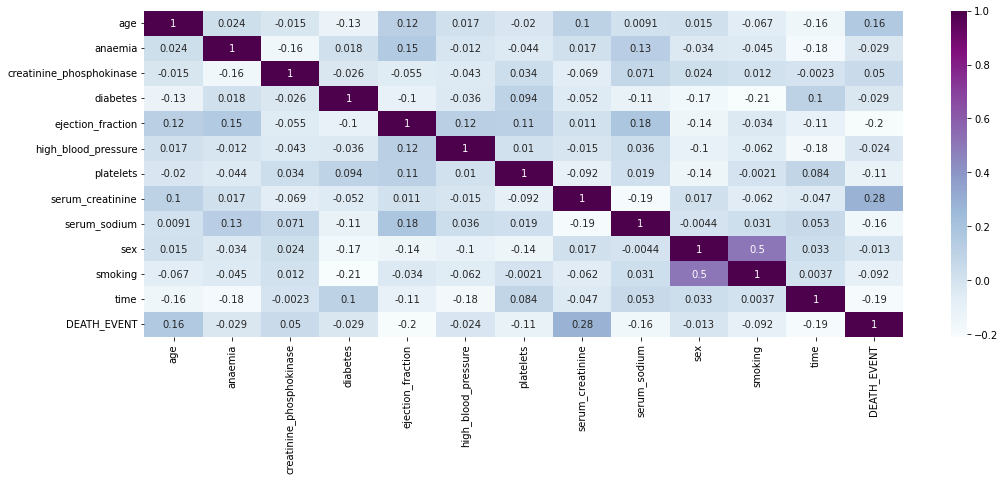

In [623]:
plt.figure(figsize = (17,6))
sns.heatmap(dataSet.corr(), annot = True, cmap="BuPu")
plt.show()

*Podemos ver que creatine_phospockinase muy poca correlacion con otras variable excepto anemia (y anemia no tiene fuerte correlacion con muerte).
Lo mismo sucede con diabetes.*

*Generamos una copia del data set para poder manipularlo*

In [624]:
newDataSet = dataSet.copy()

*Checkeamos la cantidad de valores fuera de rango*

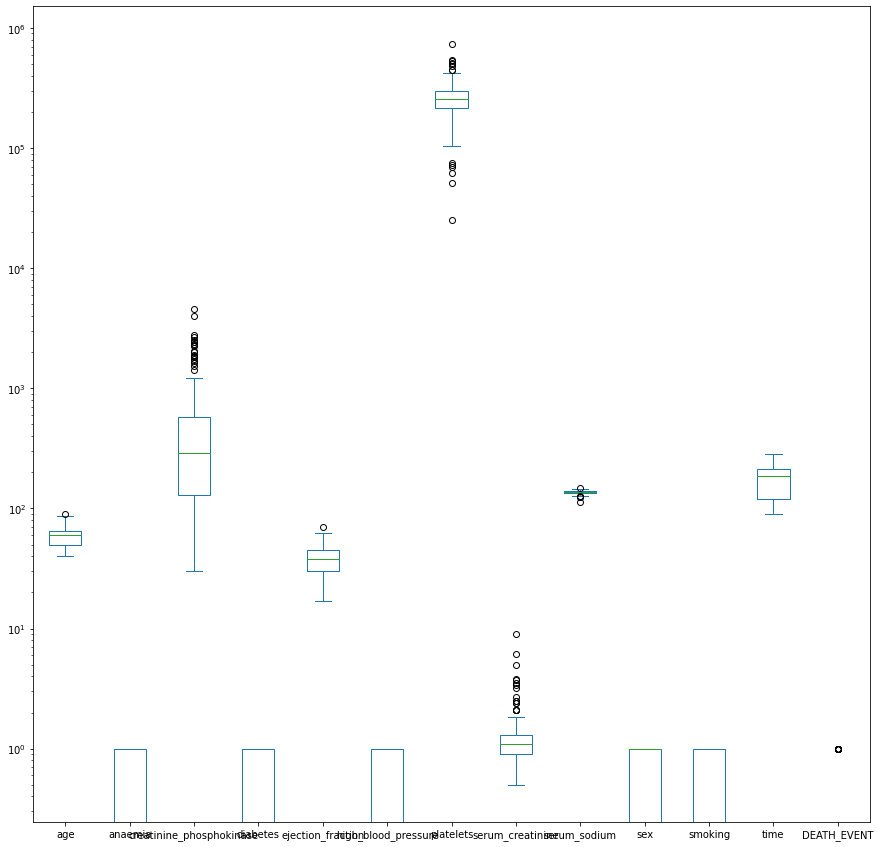

In [625]:
dataSet.plot(kind = 'box', figsize = (15, 15), logy = True);

*No podemos usar scaler con tantos puntos fuera de rango. 
Creamos funciones que se encarguen de encontrar y sacar puntos fuera de rango sobre cada variable.*

In [626]:
def mostrarDesubicados (DF, col, limFact):
    Q1 = DF[col].quantile(0.25)
    Q3 = DF[col].quantile(0.75)
    IQR = Q3 - Q1   
    lower = Q1 - limFact*IQR
    higher = Q3 + limFact*IQR
    return ((DF[col] < lower) | (DF[col] > higher)).sum()

def quitarDesubicados (DF, col, limFact):
    Q1 = DF[col].quantile(0.25)
    Q3 = DF[col].quantile(0.75)
    IQR = Q3 - Q1   
    lower = Q1 - limFact*IQR
    higher = Q3 + limFact*IQR
    DF = DF.loc[(DF[col] >= lower) & (DF[col] <= higher)]
    return DF

In [627]:
outliners = []
for col in list(newDataSet):
    outliners.append(mostrarDesubicados(newDataSet, col, 1.5))
dic = dict(zip(np.array(list(newDataSet)), np.array(outliners)))
print(dic)

{'age': 1, 'anaemia': 0, 'creatinine_phosphokinase': 21, 'diabetes': 0, 'ejection_fraction': 1, 'high_blood_pressure': 0, 'platelets': 14, 'serum_creatinine': 17, 'serum_sodium': 5, 'sex': 0, 'smoking': 0, 'time': 0, 'DEATH_EVENT': 29}


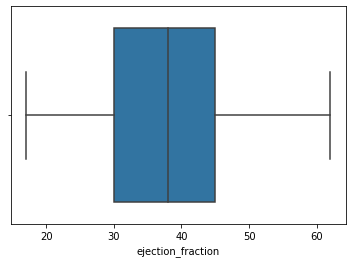

In [628]:
newDataSet = quitarDesubicados(newDataSet, 'ejection_fraction', 1.5)
fig, ax = plt.subplots()
sns.boxplot(x = newDataSet['ejection_fraction']);

In [629]:
mostrarDesubicados(newDataSet, 'ejection_fraction', 1.5)

0

*Confirmamos la efectividad de las funciones de extraccion de datos excepcionales funciona. Repetimos la extraccion de puntos fueras de rangos esperados para el resto de las columnas*

In [630]:
for col in list(newDataSet):
    newDataSet = quitarDesubicados(newDataSet, col, 1.5)
outliners = []
for col in list(newDataSet):
    outliners.append(mostrarDesubicados(newDataSet, col, 1.5))
dic = dict(zip(np.array(list(newDataSet)), np.array(outliners)))
print(dic)

{'age': 0, 'anaemia': 0, 'creatinine_phosphokinase': 0, 'diabetes': 0, 'ejection_fraction': 2, 'high_blood_pressure': 0, 'platelets': 3, 'serum_creatinine': 5, 'serum_sodium': 3, 'sex': 0, 'smoking': 0, 'time': 0, 'DEATH_EVENT': 0}


In [631]:
newDataSet.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.0
mean,57.834691,0.463415,336.211382,0.439024,40.154472,0.333333,252885.075122,1.048374,137.203252,0.617886,0.317073,180.227642,0.0
std,10.213601,0.500699,279.878201,0.498298,10.546565,0.473333,63507.562847,0.259992,3.813177,0.487892,0.467239,53.976287,0.0
min,40.000000,0.000000,30.000000,0.000000,17.000000,0.000000,127000.000000,0.700000,125.000000,0.000000,0.000000,90.000000,0.0
25%,50.000000,0.000000,115.000000,0.000000,35.000000,0.000000,212500.000000,0.900000,135.000000,0.000000,0.000000,121.000000,0.0
50%,58.000000,0.000000,212.000000,0.000000,38.000000,0.000000,259000.000000,1.000000,137.000000,1.000000,0.000000,192.000000,0.0
75%,65.000000,1.000000,582.000000,1.000000,45.000000,1.000000,282500.000000,1.200000,140.000000,1.000000,1.000000,215.000000,0.0
max,85.000000,1.000000,1202.000000,1.000000,62.000000,1.000000,406000.000000,1.800000,148.000000,1.000000,1.000000,285.000000,0.0


*No se extrayeron todos los datos excepcionales pero se deja con una sola iteración ya que para llegar a cero debemos iterar 3 veces y nos quedan 111 datos. Muy pocos datos*

*Se extrayeron en total 66 casos de 189, quedando un dataser del 35% de tamaño respecto del anterior. Se considera aceptable para proseguir utilizando este nuevo dataset filtrado*

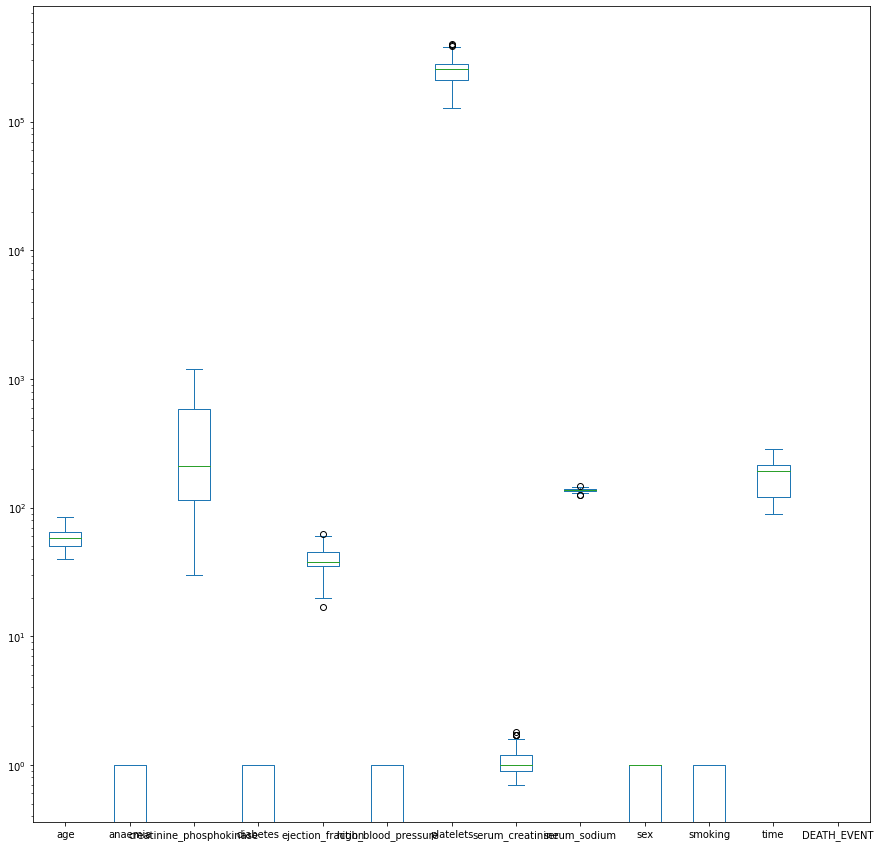

In [632]:
newDataSet.plot(kind = 'box', figsize = (15, 15), logy = True);

*A continuacion veremos los solapamientos de puntos para ver que metodos de machine learning son mejores para utilizar*

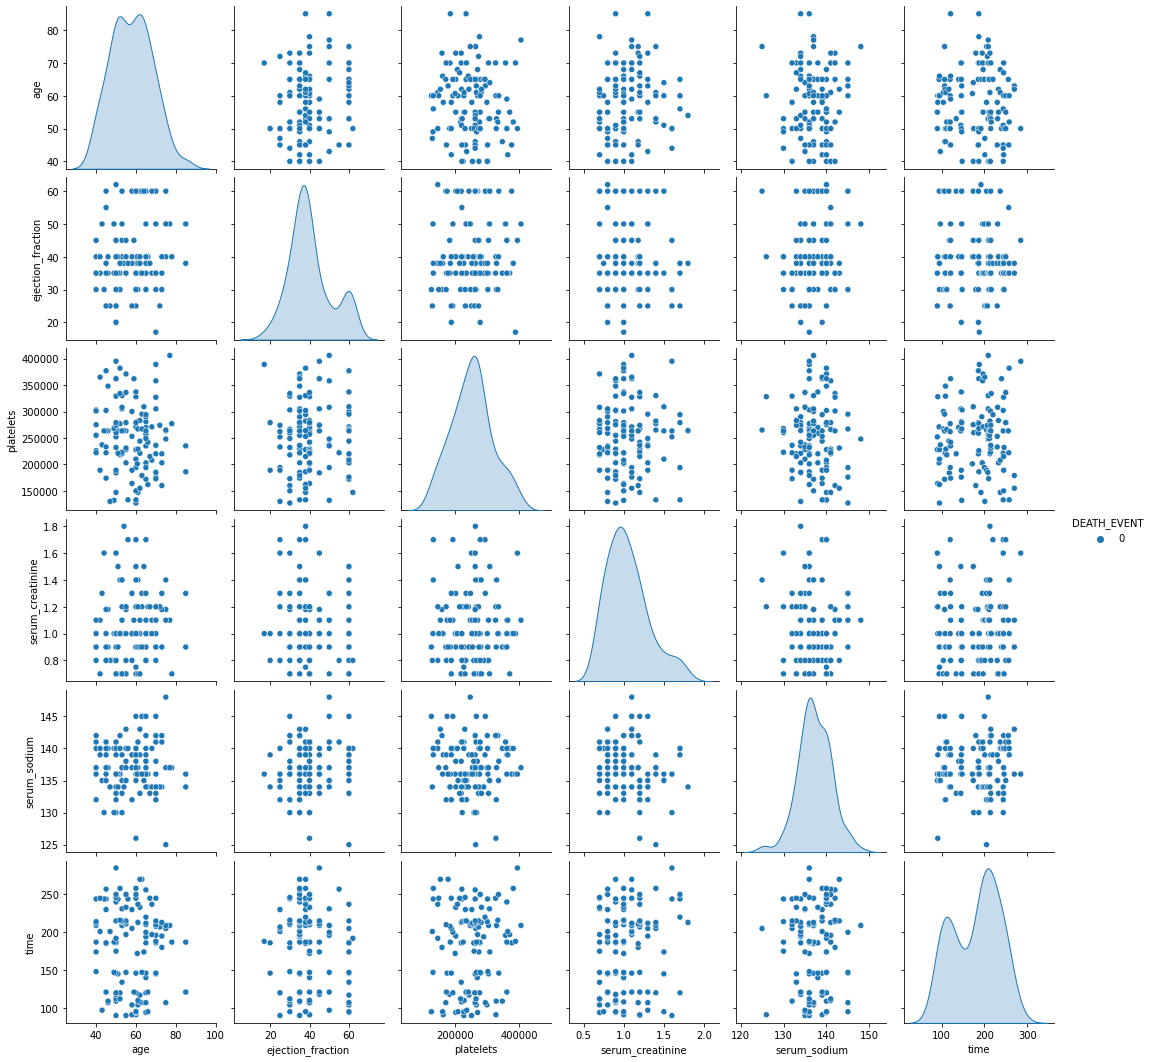

In [633]:
# Vemos solo las variables no booleanas
sns.pairplot(newDataSet[['age','ejection_fraction','platelets','serum_creatinine','serum_sodium','time','DEATH_EVENT']], hue = 'DEATH_EVENT');

*Claramente no podemos aplicar regresion lineal. Podemos aplicar Decision Tree, Random Forest o KNN para asi poder agrupar el importante solapamiento que se puede observar*

*____________________________________________________________________________*

**Analisis de valores de variables**

Estudiando cada una de las medidas medicas, sabemos que valores son normales

*Anemia* = falla en una correcta distribución del oxígeno en sangre. No implica riesgo directo en falla cardíaca.


*Presión sanguínea* = el principal riesgo derivado de la hipertensión es el de ataques cardíacos, así como también de ACV y aumento del glaucoma por excesiva presión ocular sobre la retina.

***Rango de presiones       Sistólica        Diastólica***

         Bajo                  < 90             < 60

         Normal             [90 - 120)        [60 - 80)

         Elevada            [120 - 129)       [60 - 80)
         
         Alta                  > 129            > 80

*Creatinina fosfoquinasa* = conocida como creatinquinasa, es un clásico indicador de que el usuario tiene una aritmia cardíaca o que está por hacer un infarto cardíaco dentro de las 24 a 36 hs. Su aumento también puede deberse a otros factores como quemaduras o ejercicio intenso.

***CPK normal values: 10 - 120 mcg/L***


*Fraccion de eyección* = indica qué tanta sangre logra evacuar el corazón. Esta relacionado a la fuerza del mismo y es un indicador de infacto cardíaco por mal bombeo de sangre o problemas en las válvulas cardíacas.

***Fraction ejection normal values: 50 - 75 %***


*Plaquetas en sangre* = las plaquetas se encargan de coagular sangre para prevenir su fuga (hacer cascaritas). 

En caso de tener los niveles bajos, podemos estar frente a un caso peligroso de trombosis interna. Puede ser causa de infarto por pérdida de sangre.

Altos niveles de plaquetas puede implicar una existencia de celulas anormales en la médula roja o estar cursando anemia, cancer, infección o inflamación.

Niveles anormales junto con sintomas de coagulaciones en las extremidades, de no ser tratados pueden generar un ataque cardíaco o desmayo.

***CBC normal values: 150.000 - 450.000 un/microL***


*Creatinina en suero* = esta vinculado al funcionamiento de los riñones. La creatinina es un desperdicio que debe ser filtrado por los riñones. En caso de tener elevadas cantidades en sangre, implica que los riñones no estan funcionando bien.

***Concentración normal de creatinina en suero:***

        Hombres: 0,7 - 1,3 mg/dL             Mujeres: 0,6 - 1,1 mg/dL

***Riesgo de infarto según niveles de creatinina:***

        Infarto Alto:           > 1,31 mg/dL (percentil 90vo)
        Hisquemia Alta:         > 1,47 mg/dL (percentil 97,5)


*Sodio en suero* = es un indicador para conocer el nivel de electrolitos, acidos, agua en sangre y el funcionamiento renal. Niveles altos de sodio se asocian a un alto riesgo de desarrollar hipertensión.

***Concentración normal de sodio en suero: 135 - 147 mmol/L***

______________________________________________________________________

***Estudio un data set de Pasa/NoPasa para cada parametro y si muere o no***

*Para profundizar el estudio, reemplazaremos los valores de los análisis segán si están dentro del rango normal o no*
*Este procesamiento de datos hace muy rígido el análisis ya que no pondera la lejanía de los valores respecto de su rango normal. Es para una lectura vaga*

In [634]:
acceptanceDataSet = newDataSet.copy()

acceptanceDataSet.creatinine_phosphokinase = np.where((acceptanceDataSet.creatinine_phosphokinase < 10) | (acceptanceDataSet.creatinine_phosphokinase > 120), 1, 0)
acceptanceDataSet.ejection_fraction = np.where((acceptanceDataSet.ejection_fraction < 50) | (acceptanceDataSet.ejection_fraction > 75), 1, 0)
acceptanceDataSet.platelets = np.where((acceptanceDataSet.platelets < 150000) | (acceptanceDataSet.platelets > 450000), 1, 0)
#acceptanceDataSet.serum_creatinine = np.where((((acceptanceDataSet.sex = 1)&((acceptanceDataSet.serum_creatinine < 0.7) | (acceptanceDataSet.serum_creatinine > 1.3))) | ((acceptanceDataSet.sex = 0)&((acceptanceDataSet.serum_creatinine < 0.6) | (acceptanceDataSet.serum_creatinine > 1.1)))), 1, 0)
acceptanceDataSet.serum_creatinine = np.where((acceptanceDataSet.serum_creatinine < 0.7) | (acceptanceDataSet.serum_creatinine > 1.3), 1, 0)
acceptanceDataSet.serum_sodium = np.where((acceptanceDataSet.serum_sodium < 135) | (acceptanceDataSet.serum_sodium > 147), 1, 0)

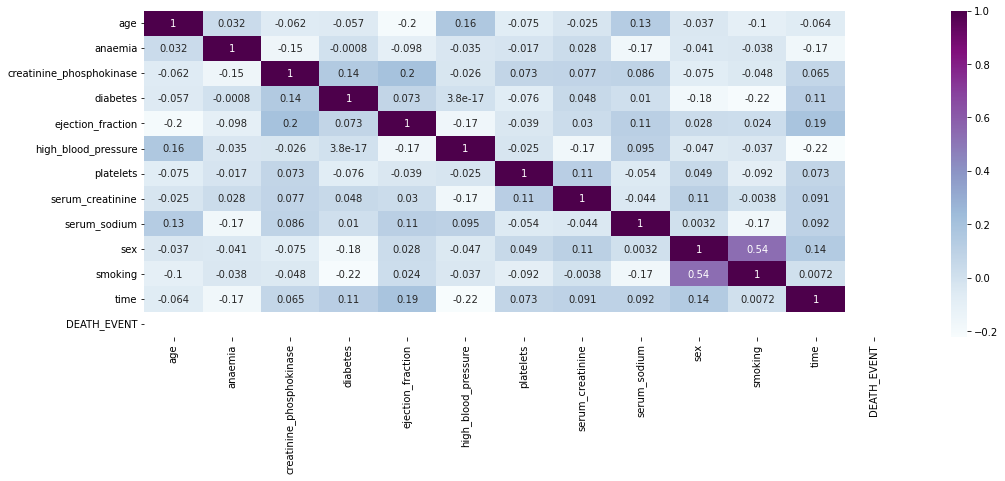

In [635]:
plt.figure(figsize = (17,6))
sns.heatmap(acceptanceDataSet.corr(), annot = True, cmap="BuPu")
plt.show()

In [636]:
acceptDeathDataSet = acceptanceDataSet[acceptanceDataSet['DEATH_EVENT'] == 1]
acceptAliveDataSet = acceptanceDataSet[acceptanceDataSet['DEATH_EVENT'] == 0]

In [637]:
deathAspects = {}
preDF = acceptDeathDataSet.drop(['age', 'time','DEATH_EVENT'], axis = 1)
for col in list(preDF):
    case = preDF[col].value_counts(normalize=True)
    deathAspects[col] = case.loc[1]*100
    print(col, "=", '{0:.1f}'.format(deathAspects[col]),"%")

KeyError: 1

In [ ]:
aliveAspects = {}
preDF = acceptAliveDataSet.drop(['age', 'time','DEATH_EVENT'], axis = 1)
for col in list(preDF):
    case = preDF[col].value_counts(normalize=True)
    aliveAspects[col] = case.loc[1]*100
    print(col, "=", '{0:.1f}'.format(aliveAspects[col]),"%")

anaemia = 44.8 %
creatinine_phosphokinase = 69.3 %
diabetes = 42.9 %
ejection_fraction = 76.7 %
high_blood_pressure = 35.6 %
platelets = 6.1 %
serum_creatinine = 13.5 %
serum_sodium = 22.7 %
sex = 63.2 %
smoking = 30.7 %


**Devolución de valores - un primer aproach predictivo:**

*A traves de los porcentajes recien desplegados, podemos ver como existe una diferencia notoria de porcentaje de gente con ciertos valores del estudio no aceptable entre los muertos y vivos*

*Mayor porcentaje de la gente que murió presentaba niveles anormales de:* 
    
    creatinina en sangre 
    creatinina fosfoquinasa
    sodio en sangre
    hipertensión
    fracción de eyección

*Es posible que varios de estos valores esten de alguna forma vinculados, como el nivel de sodio e hipertensión.*

*Ver que los niveles de creatinina en sangre muestran una diferencia de porcentaje de irregularidades entre muertos y vivos, nos abre la pregunta de si las fallas renales son una causa de infacto cardíaco.*

*En contrapartida a lo que uno estimaría a simple previo a estos análisis, los reportes de niveles anormales de creatinina fosfoquinasa no son totalmente dispares entre vivos y muertos. Hablando de una encima que eleva sus valores previo a un infarto, da pie a pensar que podría no ser un indicador tan fiable.*

In [ ]:
acceptDeathDataSet.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.0
mean,66.306016,0.524590,0.819672,0.393443,0.852459,0.442623,0.065574,0.377049,0.344262,0.672131,0.360656,69.213115,1.0
std,13.530662,0.503539,0.387651,0.492568,0.357588,0.500819,0.249590,0.488669,0.479070,0.473333,0.484176,63.762610,0.0
min,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.0
25%,57.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000,1.0
50%,68.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,43.000000,1.0
75%,75.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,95.000000,1.0
max,95.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,241.000000,1.0


In [ ]:
acceptAliveDataSet.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.00000,163.000000,163.000000,163.000000,163.000000,163.000000,163.0
mean,58.752558,0.447853,0.693252,0.429448,0.766871,0.355828,0.06135,0.134969,0.226994,0.631902,0.306748,156.392638,0.0
std,10.630378,0.498806,0.462565,0.496523,0.424127,0.480239,0.24071,0.342744,0.420179,0.483774,0.462565,66.965574,0.0
min,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,12.000000,0.0
25%,50.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,94.000000,0.0
50%,60.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,148.000000,0.0
75%,65.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000,0.000000,1.000000,1.000000,212.500000,0.0
max,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,285.000000,0.0


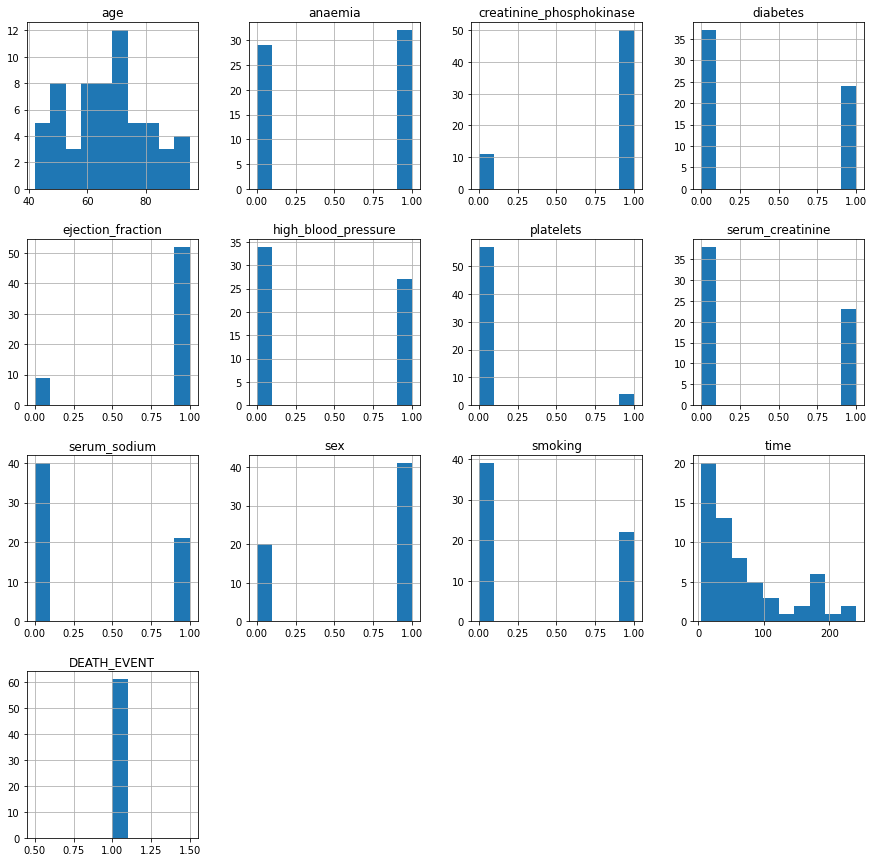

In [ ]:
acceptDeathDataSet.hist(figsize = (15,15));

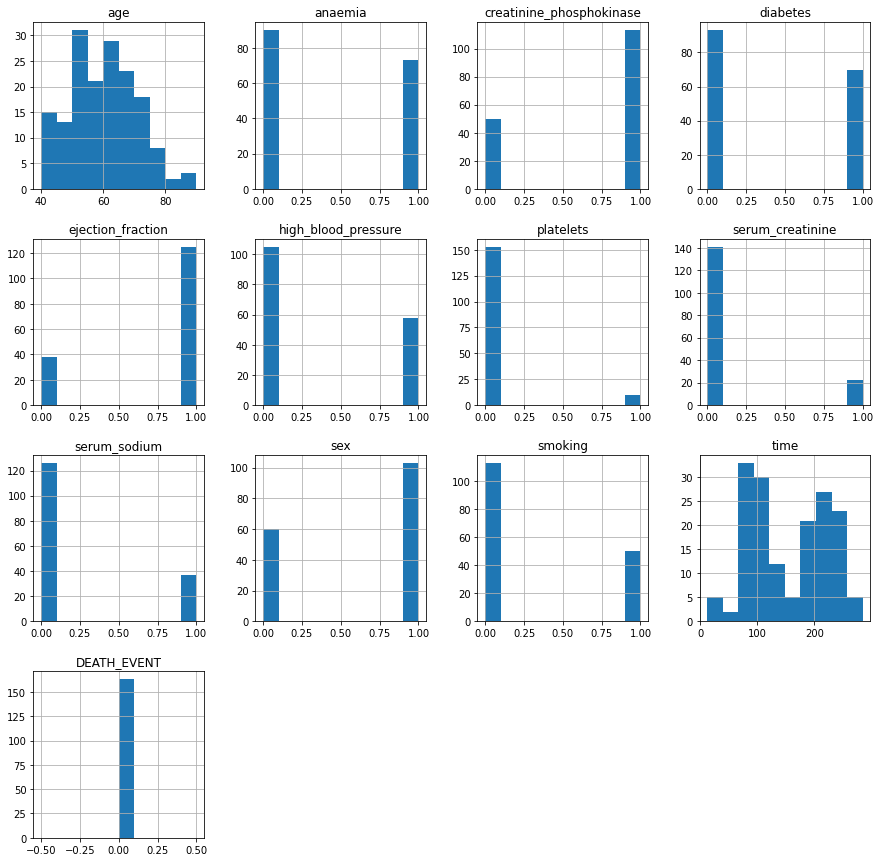

In [ ]:
acceptAliveDataSet.hist(figsize = (15,15));

**PARTE 2: MANIPULACIÓN DE DATOS Y ANÁLISIS PREDICTIVO**

In [ ]:
## sacamos columnas que no aportan al estudio ni son razones de falla cardiaca
newDataSet.drop(['creatinine_phosphokinase'], axis=1, inplace = True)

**Ecualizacion de valores**

*Debido a la diferencia en escalas de valores de las variables dadas, debemos ecualizarlas. Lo podemos hacer mediante normalizacion o estandarizacion.*

*Como tenemos variables booleanas con valores entre 0 y 1, optamos por normalizar.*

In [ ]:
scaler = MaxAbsScaler()
scaler.fit(newDataSet)
scaled = scaler.transform(newDataSet)
scaled_newDataSet = pd.DataFrame(scaled, columns = newDataSet.columns)
scaled_newDataSet.head()

,age,anaemia,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,0.789474,0.0,0.0,0.307692,1.0,0.620609,0.904762,0.878378,1.0,0.0,0.014035,1.0
1,0.684211,0.0,0.0,0.307692,0.0,0.379391,0.619048,0.871622,1.0,1.0,0.024561,1.0
2,0.526316,1.0,0.0,0.307692,0.0,0.491803,0.904762,0.925676,1.0,0.0,0.024561,1.0
3,0.947368,1.0,0.0,0.615385,1.0,0.477752,1.000000,0.891892,1.0,1.0,0.028070,1.0
4,0.789474,1.0,0.0,0.230769,0.0,0.297424,0.571429,0.925676,1.0,0.0,0.035088,1.0


**Creacion del conjunto de entrenamiento y prueba**

In [ ]:
X = newDataSet.drop('DEATH_EVENT', axis = 1)
y = newDataSet['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

*____________________________________________________________________________*

**Clustering**

*Veamos si encontramos fuerte vinculacion entre variables a ver si podemos sacar alguna del dataset*

In [ ]:
## Genero un dataframe con los aspectos mas importantes segun el paper
mostRelevantData = dataSet[['ejection_fraction', 'serum_creatinine', 'DEATH_EVENT']].copy()

c:\Users\elfee\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


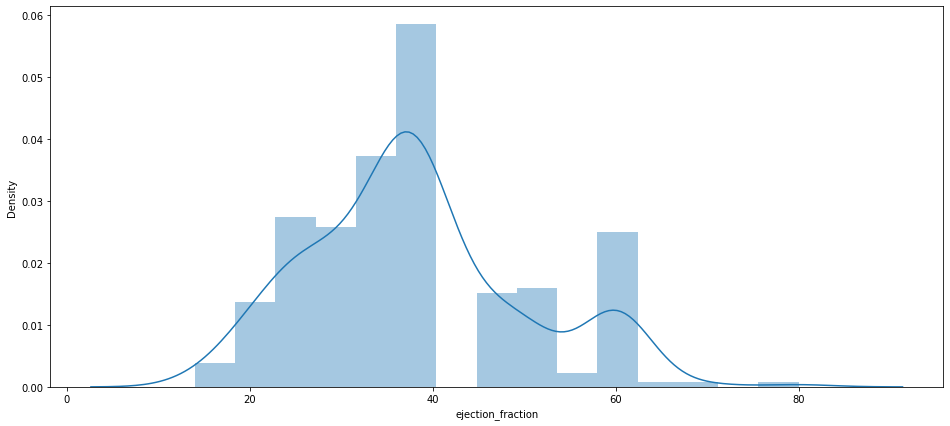

In [ ]:
fig, ax = plt.subplots(figsize = (16,7));
sns.distplot(mostRelevantData.iloc[:, 0]);

c:\Users\elfee\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


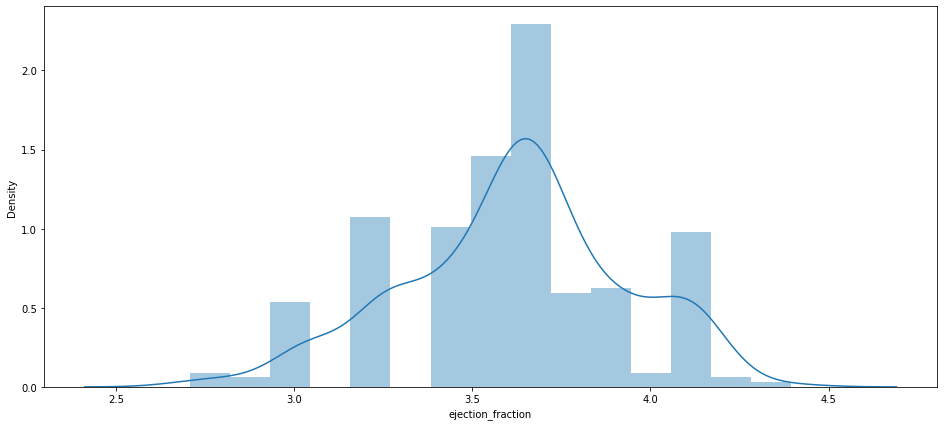

In [ ]:
# LOGARITMICO
fig, ax = plt.subplots(figsize=(16,7));
sns.distplot(np.log1p(mostRelevantData.iloc[:,0]));

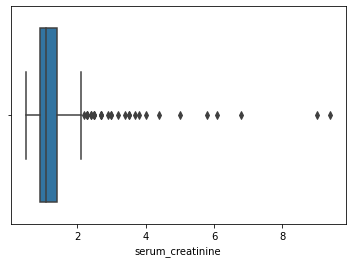

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(x = mostRelevantData['serum_creatinine']);

c:\Users\elfee\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


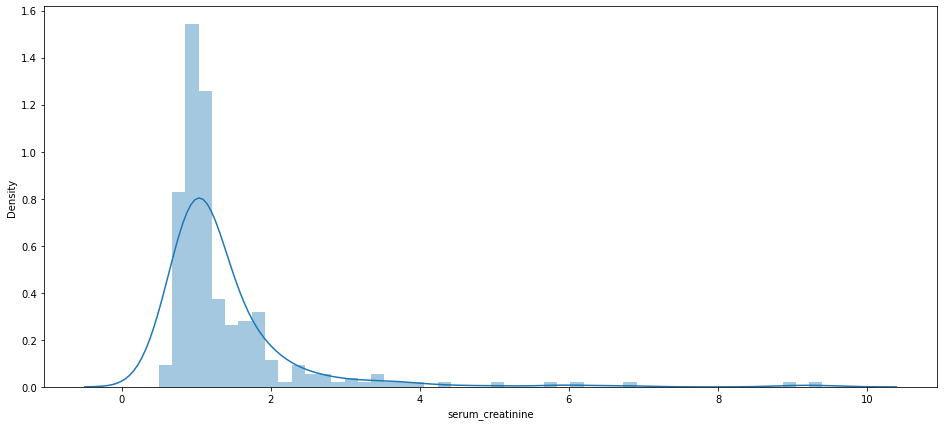

In [ ]:
# LOGARITMICO
fig, ax = plt.subplots(figsize = (16,7))
sns.distplot(mostRelevantData.iloc[:, 1]);

***Logaritmic***

c:\Users\elfee\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


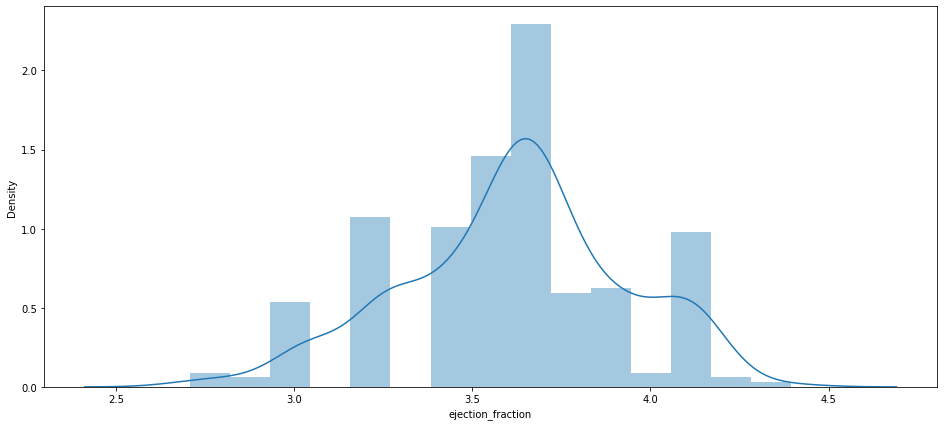

In [ ]:
fig, ax = plt.subplots(figsize=(16,7))
sns.distplot(np.log1p(mostRelevantData.iloc[:,0]));

***Random Forest:***

In [ ]:
X = mostRelevantData.drop(['DEATH_EVENT'], axis = 1)
Y = mostRelevantData['DEATH_EVENT']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

In [ ]:
Tree_model = RandomForestClassifier(n_estimators=19, random_state=2016, min_samples_leaf=8)
Tree_model.fit(X_train, Y_train)
Tree_model.score(X_test, Y_test)

0.7833333333333333

In [ ]:
X_norm = np.log1p(mostRelevantData.iloc[:, :-1])
X_norm.head()

,ejection_fraction,serum_creatinine
0,3.044522,1.064711
1,3.663562,0.741937
2,3.044522,0.832909
3,3.044522,1.064711
4,3.044522,1.308333
